# Test out hoger in notebook

In [1]:
from typing import Union

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import ruptures as rpt
from floris.utilities import wrap_180, wrap_360

from flasc import FlascDataFrame
from flasc.utilities.circular_statistics import calc_wd_mean_radial

In [2]:
def discretize(x: np.ndarray, threshold: float = 100) -> np.ndarray:
    """Discretize data points into segments.

    Args:
        x (np.ndarray): Data to discretize.
        threshold (float, optional): Threshold for discretization. Defaults to 100.

    Returns:
        np.ndarray: Discretized data.
    """
    # Handle NA values
    na = pd.isna(x)

    # Sort indices
    o = np.argsort(x)
    x_sorted = x[o]

    # Initialize group labels
    y = np.ones(len(x_sorted))

    # Find significant jumps
    d = np.diff(x_sorted)
    w = np.where(d >= threshold)[0]

    # Assign group labels
    for i in range(len(d)):
        if i in w:
            y[i + 1 :] += 1

    # Reorder and handle NAs
    y = y[np.argsort(o)]
    y[na] = np.nan

    return y

In [3]:
df = pd.read_feather('scada_exemple.ftr')

In [4]:
threshold = 100
reference = 'last'
verbose = True

In [5]:
# Make sure in FlascDataFrame format
df = FlascDataFrame(df)

In [6]:
if reference == "first":
    ref = 0
elif reference == "last":
    ref = len(df) - 1
else:
    try:
        ref = np.argmin(np.abs(df["time"].values - pd.to_datetime(reference)))
    except ValueError:
        raise ValueError(
            "Invalid reference point. Please use 'first', 'last', or a valid time string."
        )

In [8]:
# Initialize results dataframe
df_jump = pd.DataFrame(columns=["Knot", "Jump", "Turbine"])

In [37]:
# Loop over combinations of turbines
for t_i in [4]:#range(df.n_turbines):
    t_i_col = "wd_%03d" % t_i

    if verbose:
        print(f"Processing turbine {t_i}")

    for t_j in [5]:#range(df.n_turbines):
        if t_i == t_j:
            continue
        t_j_col = "wd_%03d" % t_j

        if verbose:
            print(f"...with turbine {t_j}")

        # Compute the wrapped error
        wrapped_error = wrap_180(df[t_i_col].values - df[t_j_col].values)

        # R code uses picor: Piecewise-constant regression, using
        # https://github.com/chasmani/piecewise-regression in python
        # as a replacement for picor
        # I can't find a close python equivalent for picor, so starting with ruptures
        # this is convenient as via the dependency on wind-up this is already
        # a defacto requirement for FLASC

        # Note these first lines (minus the threshold)
        # are verbatim from the example here
        # https://github.com/deepcharles/ruptures
        # presumably can improve somewhat
        algo = rpt.Pelt(model="l1", min_size=threshold).fit(wrapped_error)
        result = algo.predict(pen=10)
        # algo = rpt.Window(width=threshold, model='l1').fit(wrapped_error)
        # pen = 20 # np.log(len(wrapped_error)) * np.nanstd(wrapped_error)**2
        # print(f"Pen: {pen}")
        # result = algo.predict(pen=pen)


        # If results is length 1 or 0, no significant jumps detected, continue
        if len(result) <= 1:
            if verbose:
                print("... No significant jumps detected")
            continue

        if verbose:
            # print(f"... Jumps detected at: {result[:-1]}")
            print(f" Number of jumps: {len(result)-1}")

        # Compute the mean values in error in each of the identified segments
        # so we can compute the jump size at each jump location
        knots = result[:-1]  # Exclude the end point returned by ruptures
        values = [
            calc_wd_mean_radial(wrapped_error[start:end])
            for start, end in zip([0] + knots, knots + [len(wrapped_error)])
        ]

        # Paul's note: I added wrap_180 here though I don't think it's in original R code
        # but it feels correct to me to include it since errors 
        # should not include values > abs(180)
        values = [wrap_180(v) for v in values]

        # if verbose:
        #     print(f"... Jump values per area: {values}")

        jumps = np.diff(values)

        # if verbose:
        #     print(f"... Jump sizes: {jumps}")

        # Append result to the result dataframe
        # TODO: Not a big deal but this is a slow way to do it
        df_jump = pd.concat(
            [df_jump, pd.DataFrame({"Knot": knots, "Jump": jumps, "Turbine": t_i})]
        )


Processing turbine 4
...with turbine 5
 Number of jumps: 494


In [39]:
df_jump.Knot

0       810.0
4      2065.0
8      4460.0
12     5260.0
16     5760.0
        ...  
489     52060
490     52160
491     52260
492     52360
493     52460
Name: Knot, Length: 1450, dtype: object

In [33]:
df_jump

,Knot,Jump,Turbine
0,1830,2.794897,0
1,2070,-4.368067,0
2,2310,2.353011,0
3,3020,-2.580274,0
4,3130,4.623524,0
...,...,...,...
489,52060,-1.260391,4
490,52160,0.635590,4
491,52260,0.124131,4
492,52360,0.577936,4


In [ ]:
df_jump = (
    df_jump.assign(Count=1, Class=discretize(df_jump["Knot"].values, threshold=threshold))
    .groupby(["Class", "Turbine"])
    #TODO Original code uses a "mode" but for now taking a shortcut with median
    .agg(
        {
            "Knot": "median",  # Using median instead of shorth
            "Jump": "mean",
            "Count": "sum",
        }
    )
    .reset_index()
)


Knot      Jump  Count
Class Turbine                          
1.0   4          265.0 -3.156637      2
2.0   4          410.0  2.657651      2
3.0   4          515.0  1.001608      2
4.0   4          615.0 -3.164829      2
5.0   0          810.0 -0.070601      1
...                ...       ...    ...
492.0 4        52260.0  0.124131      2
493.0 0        52360.0  0.056769      1
      4        52360.0  0.577936      2
494.0 0        52460.0 -0.447198      1
      4        52460.0  0.406734      2

[952 rows x 3 columns]

In [34]:

print(f"Df_jump size: {df_jump.shape}")
df_jump_orig = df_jump.copy()

# Group and summarize change points
df_jump = (
    df_jump.assign(Count=1, Class=discretize(df_jump["Knot"].values, threshold=threshold))
    .groupby(["Class", "Turbine"])
    #TODO Original code uses a "mode" but for now taking a shortcut with median
    .agg(
        {
            "Knot": "median",  # Using median instead of shorth
            "Jump": "mean",
            "Count": "sum",
        }
    )
    .reset_index()
    .query(f"Count > {np.floor(df.n_turbines/2)}")
    .sort_values("Count", ascending=False)
    .drop_duplicates("Class")
    .sort_values("Class")
)

print(f"Df_jump size (after summarizing): {df_jump.shape}")

Df_jump size: (23452, 3)
Df_jump size (after summarizing): (462, 5)


In [35]:
df_jump

,Class,Turbine,Knot,Jump,Count
0,1.0,0,810.0,-0.070601,62
4,2.0,0,2065.0,-0.033015,71
8,3.0,0,4460.0,-0.170122,220
12,4.0,0,5260.0,0.144313,261
16,5.0,0,5760.0,-0.843092,29
...,...,...,...,...,...
1825,458.0,0,52060.0,-0.387025,29
1829,459.0,0,52160.0,0.377298,29
1833,460.0,0,52260.0,-0.218838,29
1837,461.0,0,52360.0,0.056769,29


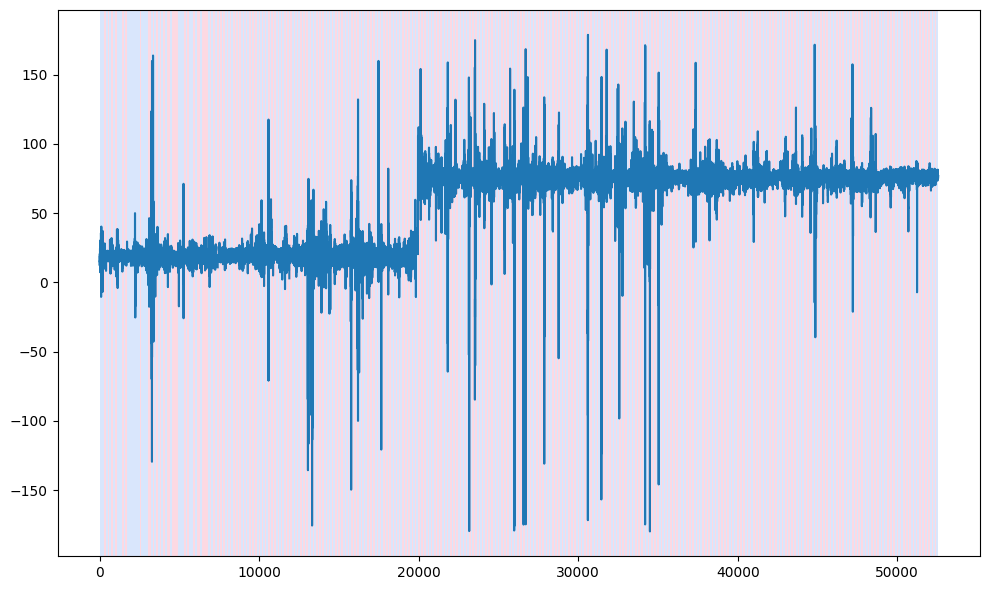

In [31]:
fig, ax_arr = rpt.display(wrapped_error, result,  figsize=(10, 6))
plt.show()